In [1]:
from __future__ import print_function, division

from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torchvision.datasets.folder import *
import PIL

import matplotlib.pyplot as plt
import time
import os
import copy
from itertools import chain
import pretrainedmodels.utils as utils
import pretrainedmodels

from torchviz import make_dot, make_dot_from_trace

%matplotlib inline
plt.ion()   # interactive mode
BATCH = 2
N_layers = 2 # LSTM

In [2]:
# Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Special class
class MultiImageFolder(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, len_seq=4):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx, [".jpg",".jpeg",".png"])
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.len_seq =len_seq

    def __len__(self): 
        return len(self.imgs)//self.len_seq
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        img_l = []
        target_l = []
        for i in range(self.len_seq):
            path, target = self.imgs[self.len_seq*index+i]
            img = self.loader(path)
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                target = self.target_transform(target)
            if target_l and target != target_l[0]: break
            img_l += [img]
            target_l += [target]

        return img_l, target

# Datasets
data_dir = './LittlePlaNet/data/cities_L/'
image_datasets = {x: MultiImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x], len_seq=8)
                   for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH,
                                           shuffle=True, num_workers=8, drop_last=True)
                   for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [3]:
import torch
import torch.nn as nn

device = torch.device("cuda")
m = torch.load("models/resnet50_trained")

num_ftrs = m.fc.in_features
hidden = 80


In [14]:
?nn.LSTM

In [12]:
class SeqModel(nn.Module):
    def __init__(self, num_ftrs, hidden, transf, num_layers=N_layers):
        super(SeqModel, self).__init__()        
        self.hidden = hidden
        self.num_ftrs = num_ftrs
        
        self.emb = transf
        self.L = nn.LSTM(num_ftrs, hidden, num_layers=num_layers, bidirectional = True).to(device)
        self.h2la = nn.Linear(2*hidden, len(class_names)).to(device)
        self.drop = nn.Dropout(0.3)
        self.h = (torch.zeros(2*N_layers, BATCH ,hidden).to(device),
                  torch.zeros(2*N_layers,BATCH ,hidden).to(device))

    def init_hidden(self):
        self.h = (torch.randn(self.num_layers, BATCH ,self.hidden).to(device),
                  torch.randn(self.num_layers, BATCH ,self.hidden).to(device))
        
    def forward(self,inp):        
        X = torch.stack([self.emb(inp[i].to(device)) for i in range(len(inp))]).squeeze() 
#         print(X.shape)
        o,h = self.L(X.view(len(inp), -1 , self.num_ftrs),self.h)
        res = self.h2la(nn.Softmax(dim=1)(self.drop(o).mean(0)))
        return res

In [13]:
x,y = next(iter(nt_dataloader))
y = y.to(device)
sm = SeqModel(num_ftrs, hidden, nn.Sequential(*list(m.children())[:-1]).to(device))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(chain(sm.L.parameters(),sm.h2la.parameters()) , lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)


In [7]:

# inputs, classes = next(iter(dataloaders['train']))
# inputs = torch.stack( inputs )
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs[:,1,:,:,:])

# imshow(out, title=class_names[classes[1]])

# Reset optimizer
optimizer_ft = optim.Adam(chain(sm.L.parameters(),sm.h2la.parameters()) , lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    hist = {"train":[], "val":[]}
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':            
                scheduler.step()
                model.train()  # Set model to training mode
                model.emb.eval()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                                            # last batch classes
                    outputs = model(inputs)                                                
                    _, preds = torch.max(outputs, 1)
                    labels,
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * BATCH
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            hist[phase] += [[epoch_loss, epoch_acc]]
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [14]:
sm, hist = train_model(sm, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.3155 Acc: 0.0888
val Loss: 2.3213 Acc: 0.0000

Epoch 1/24
----------
train Loss: 2.3133 Acc: 0.0970
val Loss: 2.3503 Acc: 0.0147

Epoch 2/24
----------
train Loss: 2.3117 Acc: 0.0916
val Loss: 2.3262 Acc: 0.0147

Epoch 3/24
----------
train Loss: 2.3124 Acc: 0.0898
val Loss: 2.2863 Acc: 0.2206

Epoch 4/24
----------
train Loss: 2.3164 Acc: 0.0898
val Loss: 2.2917 Acc: 0.2206

Epoch 5/24
----------
train Loss: 2.3025 Acc: 0.0934
val Loss: 2.3014 Acc: 0.0147

Epoch 6/24
----------
train Loss: 2.3020 Acc: 0.0852
val Loss: 2.3086 Acc: 0.0147

Epoch 7/24
----------
train Loss: 2.3016 Acc: 0.1034
val Loss: 2.3133 Acc: 0.0147

Epoch 8/24
----------
train Loss: 2.3016 Acc: 0.1006
val Loss: 2.3157 Acc: 0.0147

Epoch 9/24
----------
train Loss: 2.3014 Acc: 0.0888
val Loss: 2.3132 Acc: 0.0147

Epoch 10/24
----------
train Loss: 2.2989 Acc: 0.1052
val Loss: 2.3137 Acc: 0.0147

Epoch 11/24
----------
train Loss: 2.2989 Acc: 0.1061
val Loss: 2.3140 Acc: 0.0147

Ep

In [4]:
def avgmodel(m, inp):
    mn = torch.stack([m(inp[i].to(device)) for i in range(len(inp))]).squeeze().mean(0)
    if len(mn.shape) == 1: return mn.max(0)[1]
    return mn.max(1)[1]

In [11]:
x, y = next(iter(dataloaders['train']))
mn = torch.stack([m(x[i].to(device)) for i in range(len(x))]).squeeze().mean(0)
print(mn)
print(mn.shape)
mn.max(1)[1]

tensor([[ 0.2475, -0.4040, -0.5777, -0.0768,  0.0328,  0.4112,  0.7051,
          0.2025,  1.3419, -0.9156],
        [ 0.1969,  0.5837, -0.0008,  0.5255,  0.1755, -0.2451,  1.1130,
         -0.7582,  0.0414, -0.3068]], device='cuda:0')
torch.Size([2, 10])


tensor([ 8,  6], device='cuda:0')

In [15]:
newtestds = MultiImageFolder("data/cities/",data_transforms["test"],len_seq=2)
nt_dataloader = torch.utils.data.DataLoader(
    newtestds,batch_size=BATCH, shuffle=True, num_workers=4, drop_last=True)
class_names = newtestds.classes

0.652
0.6519748352746799


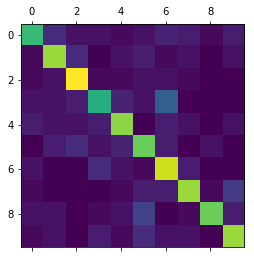

In [16]:
preds = []
Y = []
for x,y in nt_dataloader:
    prs = avgmodel(m,x)
#     prs = sm(x)[len(x)-1,:,:].max(1)[1]
    preds +=list(prs)
    Y += list(y)
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

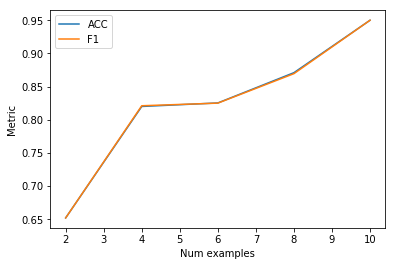

In [18]:
x = [10,8,6,4, 2 
]
y1= [0.95,0.8709677419354839,0.8253012048192772,0.82, 0.652
]
y2=[0.95,0.8694682717292381,0.8250352445494066,0.8210904969040139, 0.6519748352746799
]

plt.plot(x,y1, label="ACC")
plt.plot(x,y2, label="F1")
plt.ylabel("Metric")
plt.xlabel("Num examples")
plt.legend()

0.6
0.5748962905000057


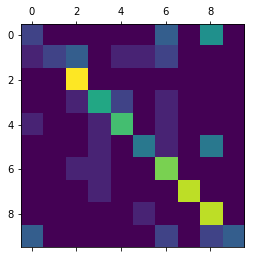

In [13]:
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

In [16]:
len(sm(x))

tensor([[[ 0.0395,  0.1186,  0.2006,  0.0897,  0.0829,  0.0907,  0.0668,
           0.0928,  0.1574,  0.0610],
         [ 0.0296,  0.1044,  0.4025,  0.0485,  0.0662,  0.0468,  0.0407,
           0.0692,  0.1449,  0.0471]],

        [[ 0.0172,  0.0475,  0.5648,  0.0503,  0.0398,  0.0293,  0.0723,
           0.0562,  0.0728,  0.0498],
         [ 0.0143,  0.0660,  0.3085,  0.0573,  0.0603,  0.0474,  0.0964,
           0.0531,  0.1701,  0.1265]],

        [[ 0.0193,  0.0432,  0.3705,  0.0484,  0.1606,  0.0406,  0.0742,
           0.0473,  0.1235,  0.0724],
         [ 0.0069,  0.0686,  0.5940,  0.0305,  0.0597,  0.0289,  0.0387,
           0.0354,  0.1119,  0.0253]],

        [[ 0.0192,  0.0687,  0.4567,  0.0727,  0.0475,  0.0289,  0.0297,
           0.0693,  0.1643,  0.0430],
         [ 0.0101,  0.0444,  0.6012,  0.0382,  0.0645,  0.0278,  0.0256,
           0.0537,  0.0962,  0.0383]],

        [[ 0.0402,  0.0892,  0.2531,  0.0645,  0.0485,  0.0333,  0.0593,
           0.0697,  0.1940,  0.

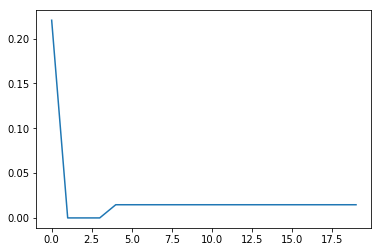

In [15]:
plt.plot([b for a,b in hist["val"]])